In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from itertools import chain
from typing import List, Tuple
from pprint import pprint
from joblib import Parallel
from joblib import delayed

%matplotlib inline

/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:529: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


<a id='Token_Classification'></a>
# Token Classification


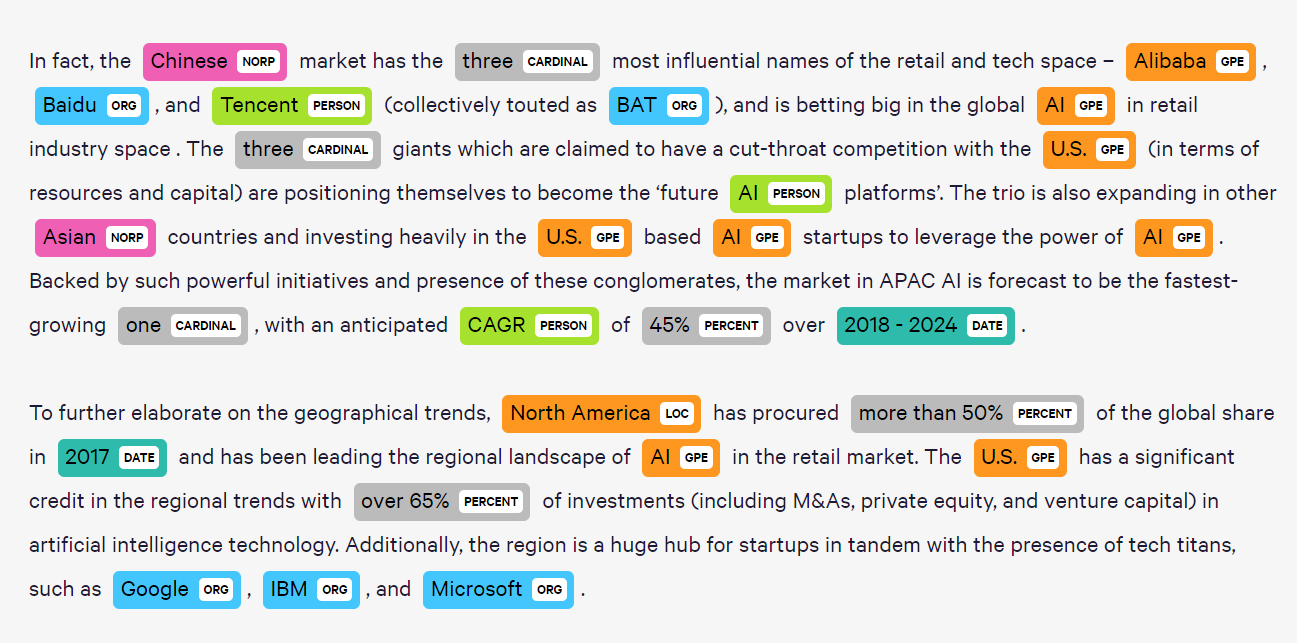

## Task Description 

Build Model, which can take on input some text and return all unique locations from the text

Example:

H("Їздив Гриць в Київ і був на Хрещатику. На Хрещатику Грицю дуже сподобалось") = {"Київ", "Хрещатику"}

## Data

### uk_geo_dataset
Ukrainian dataset [Corpora Ukrainian](https://huggingface.co/datasets/ukr-models/Ukr-Synth).
Approximately contains 1M text samples with location and organization entities.
Structure:
- text (str): text sample.
- loc_markers (List[tuple]): list of markers of location entities. Left and right indices.
- org_markers (List[tuple]): list of markers of origanization entities. Left and right indices.
- per_markers (List[tuple]): list of markers of person entities. Left and right indices.

### ru_geo_dataset
russian dataset based on [nerus dataset](https://github.com/natasha/nerus).
Approximately contains 8M text samples with location and organization entities.
Structure:
- text (str): text sample.
- loc_markers (List[tuple]): list of markers of location entities. Left and right indices.
- org_markers (List[tuple]): list of markers of origanization entities. Left and right indices.
- per_markers (List[tuple]): list of markers of person entities. Left and right indices.

## Proposed Metric

Micro F1 Score = 2 * (precision * recall) / (precision + recall)

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

Definitions:
- TP: locations that are both in predicted set and real set
- FP: locations that are in predicted set and NOT in real set
- FN: locations that are NOT in predicted set and in real set

So in order to get final metric results you have to compute for each data sample TP, FP, FN separately. Than accumulate them. Than compute final precision, recall and F1

## Train/Val/Test Split

Train and Val splits are up to you 

Hidden test set is currently in labeling process and will be used for final decision making

## Production Use Case

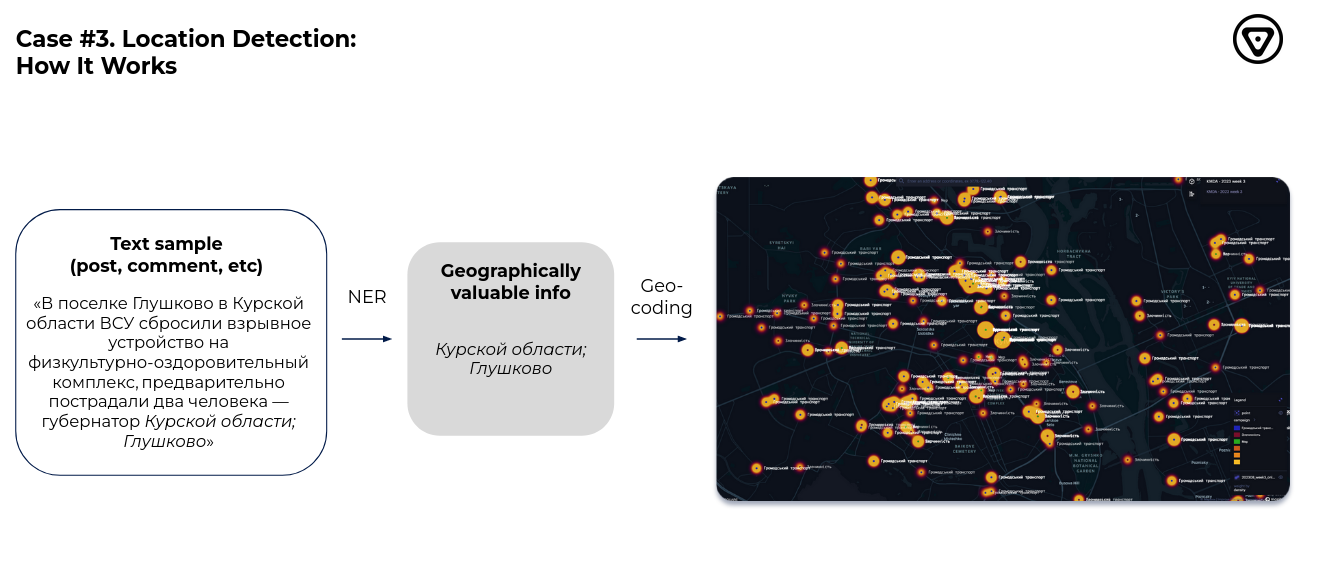

## Data Preparation

In [5]:
os.listdir("data/mantis_analytics_location_detection/")

['uk_geo_dataset_processed_v1.parquet',
 'test.csv',
 'ru_geo_dataset.csv',
 'README.md',
 'uk_geo_dataset.csv',
 'labeling_sample.csv']

In [7]:
# ru_geo_dataset = pd.read_csv("../data/mantis_analytics_location_detection/ru_geo_dataset.csv", converters={"loc_markers": eval})
uk_geo_dataset = pd.read_csv("data/mantis_analytics_location_detection/uk_geo_dataset.csv", converters={"loc_markers": eval})

In [49]:
# ru_geo_dataset

In [8]:
uk_geo_dataset

,text,loc_markers,org_markers,per_markers,is_valid
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[],0
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]",0
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[],0
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[],0
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[],0
...,...,...,...,...,...
1009995,"Траєкторія польоту цих літаків є провокуючою”,...",[],[],"[(56, 63)]",1
1009996,Якщо порівняти у відсотковому співвідношенні к...,[],[],[],1
1009997,"У інфікувалися четверо жінок, наймолодшій із н...",[],[],[],1
1009998,"Хочу запевнити, що створення Православної Церк...",[],"[(29, 56)]",[],1


In [9]:
uk_geo_dataset["language"] = "ukr"

# ru_geo_dataset["language"] = "rus"
# geo_dataset = pd.concat([ru_geo_dataset, uk_geo_dataset]).reset_index(drop=True)

geo_dataset = uk_geo_dataset

## A bit of Data Exploration

In [10]:
print("Number of data points:", geo_dataset.shape[0])
geo_dataset["language"].value_counts()

Number of data points: 1010000


ukr    1010000
Name: language, dtype: int64

In [11]:
geo_dataset["number_of_locations"] = geo_dataset["loc_markers"].apply(len)

In [12]:
print("Distribution of No/(At least one) Location")
(geo_dataset["number_of_locations"] == 0).value_counts()

Distribution of No/(At least one) Location


True     776579
False    233421
Name: number_of_locations, dtype: int64

In [13]:
print("Distribution of Number of locations")
geo_dataset["number_of_locations"].value_counts()

Distribution of Number of locations


0     776579
1     161061
2      48937
3      14815
4       4907
5       1979
6        842
7        401
8        219
9        127
10        71
11        35
12        15
13         5
16         3
21         1
19         1
15         1
14         1
Name: number_of_locations, dtype: int64

## Validation

In [14]:
geo_dataset["stratify_col"] = geo_dataset["number_of_locations"]
geo_dataset.loc[geo_dataset["number_of_locations"] >= 14, "stratify_col"] = -1 

In [15]:
geo_dataset["stratify_col"].value_counts()

 0     776579
 1     161061
 2      48937
 3      14815
 4       4907
 5       1979
 6        842
 7        401
 8        219
 9        127
 10        71
 11        35
 12        15
-1          7
 13         5
Name: stratify_col, dtype: int64

In [16]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(geo_dataset, geo_dataset["stratify_col"])]

In [17]:
X_train_fold_0, X_test_fold_0 = geo_dataset.iloc[folds_train_test_ids[0][0]], geo_dataset.iloc[folds_train_test_ids[0][1]]
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [18]:
print("Test stratify_col distribution")
X_test_fold_0["stratify_col"].value_counts(normalize=True)

Test stratify_col distribution


 0     0.768891
 1     0.159465
 2     0.048455
 3     0.014668
 4     0.004856
 5     0.001960
 6     0.000837
 7     0.000396
 8     0.000213
 9     0.000129
 10    0.000069
 11    0.000035
 12    0.000015
 13    0.000005
-1     0.000005
Name: stratify_col, dtype: float64

In [19]:
print("Train stratify_col distribution")
X_train_fold_0["stratify_col"].value_counts(normalize=True)

Train stratify_col distribution


 0     0.768890
 1     0.159467
 2     0.048452
 3     0.014668
 4     0.004859
 5     0.001959
 6     0.000833
 7     0.000397
 8     0.000218
 9     0.000125
 10    0.000071
 11    0.000035
 12    0.000015
-1     0.000007
 13    0.000005
Name: stratify_col, dtype: float64

In [20]:
def comp_metric(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn, p,  = 0.0, 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
        p += len(set(y_true_sample))

    if tp + fp == 0:
        if p == 0:
            precision = 1.0
        else:
            precision = 0.0
    else:
        precision = tp/(tp + fp)
        
    if tp + fn == 0:
        if p == 0:
            recall = 1.0
        else:
            recall = 0.0
    else:
        recall = tp/(tp + fn)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

> **TODO**: Optimize to handle zero denominator case

In [21]:
sample_1000 = geo_dataset.iloc[:1000].apply(lambda row: [row["text"][left_id:right_id] for left_id,right_id in row["loc_markers"]], axis=1)

In [22]:
print("Examples of locations")
pd.Series(list(chain(*sample_1000))).value_counts()

Examples of locations


України                     20
Україні                     17
США                         10
Україна                      9
Росія                        8
                            ..
Будапешт                     1
Шулявським шляхопроводом     1
Одеси                        1
Деснянському районі          1
Російської Федерації         1
Length: 219, dtype: int64

In [23]:
print("All correct case")
pprint(comp_metric(sample_1000, sample_1000))
print("Empty prediction")
pprint(comp_metric(sample_1000, [[] for _ in range(len(sample_1000))]))
print("All empty")
pprint(comp_metric([[] for _ in range(len(sample_1000))], [[] for _ in range(len(sample_1000))]))
print("Less predicted locations")
sample_1000_less_locations = [el[:-1] for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_less_locations))
print("More predicted locations")
sample_1000_more_locations = [el + ["Fake Location"] for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_more_locations))
print("Remove predicted duplicates")
sample_1000_no_duplicates = [list(set(el)) for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_no_duplicates))
print("Add predicted duplicates")
sample_1000_add_duplicates = [el + el for el in sample_1000]
pprint(comp_metric(sample_1000, sample_1000_add_duplicates))

All correct case
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Empty prediction
{'f1': 0, 'precision': 0.0, 'recall': 0.0}
All empty
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Less predicted locations
{'f1': 0.5129310344827587, 'precision': 1.0, 'recall': 0.34492753623188405}
More predicted locations
{'f1': 0.40828402366863903, 'precision': 0.25650557620817843, 'recall': 1.0}
Remove predicted duplicates
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}
Add predicted duplicates
{'f1': 1.0, 'precision': 1.0, 'recall': 1.0}


## Modelling

In [24]:
!python -m spacy download xx_ent_wiki_sm

/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/evgeniy/.local/bin/miniconda3/envs/iasa_nlp_env/lib/python3.9/site-packages/torch/cuda/__init__.py:529: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
2023-10-19 01:14:39.165604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-19 01:14:39.165630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a 

In [25]:
# Created by Chat GPT: https://chat.openai.com/share/7d0b5069-ec76-4cf1-a17d-558518725bbc

nlp = spacy.load("xx_ent_wiki_sm", disable=["tagger", "parser", "ner", "textcat"])

def batch_ner_labeling(texts, loc_markers_list, tokenizer, batch_size=128, n_process=16, verbose=False):
    if verbose:
        print("Applying Tokenizer")
    docs = list(tokenizer.pipe(texts, batch_size=batch_size, n_process=n_process))
    batch_results = []

    if verbose:
        print("Extracting labels")
    for doc, loc_markers in zip(docs, loc_markers_list):
        tokens = [token.text for token in doc]
        labels = ['O'] * len(tokens)
        
        for idx, token in enumerate(doc):
            for start, end in loc_markers:
                if token.idx >= start and (token.idx + len(token.text)) <= end:
                    labels[idx] = 'LOC'
                    break
        
        batch_results.append((tokens, labels))
                
    return batch_results


In [26]:
geo_dataset[
    (geo_dataset["number_of_locations"] > 10)
]

,text,loc_markers,org_markers,per_markers,is_valid,language,number_of_locations,stratify_col
1705,"При цьому в 11 областях (Волинська, Житомирськ...","[(25, 34), (36, 47), (49, 61), (63, 73), (75, ...",[],[],0,ukr,11,11
17076,Надзвичайний рівень переважатиме у Тернопільсь...,"[(35, 49), (51, 63), (65, 75), (77, 89), (91, ...",[],[],0,ukr,11,11
32805,"Це буде на вулицях Бориславській, Волинській, ...","[(19, 32), (34, 44), (46, 53), (55, 64), (66, ...",[],[],0,ukr,11,11
66889,Перший запуск технології охопить 20 міст: Київ...,"[(42, 46), (71, 88), (90, 99), (101, 108), (11...",[],[],0,ukr,12,12
78063,В операції взяли участь понад 40 пошуковців з ...,"[(46, 51), (53, 59), (61, 73), (75, 81), (83, ...",[],[],0,ukr,11,11
...,...,...,...,...,...,...,...,...
968429,"Йдеться про Харківську, Полтавську; Луганську;...","[(12, 22), (24, 34), (36, 45), (47, 55), (57, ...",[],[],0,ukr,14,-1
983508,Найбільше захищеними від корупції виявилися Ні...,"[(44, 53), (57, 66), (124, 139), (141, 146), (...",[],[],0,ukr,12,12
989804,"Боротьбу продовжили представниці Канади, Трині...","[(33, 39), (41, 50), (53, 59), (61, 68), (70, ...",[],[],0,ukr,11,11
994568,"У музичній програмі – діджеї з Франківська, Ки...","[(31, 42), (44, 49), (51, 57), (59, 64), (66, ...",[],[],0,ukr,11,11


In [69]:
print(
    "Text: ", geo_dataset.iloc[17076].text, "\n",
    "Markers: ", geo_dataset.iloc[17076].loc_markers
)

Text:  Надзвичайний рівень переважатиме у Тернопільській, Хмельницькій, Вінницькій, Житомирській, Київській, Черкаській, Дніпропетрівській, Одеській, Миколаївській, Донецькій областях та в Криму. 
 Markers:  [(35, 49), (51, 63), (65, 75), (77, 89), (91, 100), (102, 112), (114, 131), (133, 141), (143, 156), (158, 176), (182, 187)]


In [70]:
sample_tokens, sample_labels = batch_ner_labeling(
    [geo_dataset.iloc[17076].text],
    [geo_dataset.iloc[17076].loc_markers],
    tokenizer=nlp
)[0]
pprint([token for token, label in zip(sample_tokens, sample_labels) if label == "LOC"])

['Тернопільській',
 'Хмельницькій',
 'Вінницькій',
 'Житомирській',
 'Київській',
 'Черкаській',
 'Дніпропетрівській',
 'Одеській',
 'Миколаївській',
 'Донецькій',
 'областях',
 'Криму']


In [71]:
# !pip install fastparquet

In [72]:
# geo_processed_dataset = batch_ner_labeling(geo_dataset.text.to_list(), geo_dataset.loc_markers.to_list(), nlp, verbose=True)

# geo_processed_df = pd.DataFrame({
#     "tokens": [el[0] for el in geo_processed_dataset],
#     "labels": [el[1] for el in geo_processed_dataset],
# })

# geo_processed_df.to_parquet(
#     '../data/mantis_analytics_location_detection/uk_geo_dataset_processed_v1.parquet', 
#     engine='fastparquet'
# )

In [73]:
geo_processed_df = pd.read_parquet('../data/mantis_analytics_location_detection/uk_geo_dataset_processed_v1.parquet', engine='fastparquet')

In [74]:
geo_processed_df

,tokens,labels
0,"[Чим, довше, мають, скачки, тиску, гіпертензіє...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[А, поки, що, починали, цвісти, троянди, ,, ви...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Крім, того, ,, в, 2020, р, ., багато, експерт...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Сильно, сумніваюся, ,, що, ви, зупините, свій...","[O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[Цей, унікальний, правовий, важіль, утворено, ...","[O, O, O, O, O, O, O, O, O, O]"
...,...,...
1009995,"[Траєкторія, польоту, цих, літаків, є, провоку...","[O, O, O, O, O, O, O, O, O, O, O, O]"
1009996,"[Якщо, порівняти, у, відсотковому, співвідноше...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1009997,"[У, інфікувалися, четверо, жінок, ,, наймолодш...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1009998,"[Хочу, запевнити, ,, що, створення, Православн...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


> **TODO**: Read more about [parquet](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705). Why have I used it here ?

In [75]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield text

vocab = build_vocab_from_iterator(
    yield_tokens(geo_processed_df["tokens"]), 
    specials=["<unk>", "<pad>"]
)
vocab.set_default_index(vocab["<unk>"])

In [76]:
vocab_with_freq = pd.Series(list(chain(*geo_processed_df["tokens"].to_list()))).value_counts()
vocab_with_freq

,              1213097
.              1000065
"               286011
на              278425
в               236638
                ...   
Кенініса             1
Камворор             1
Рінґельблум          1
Цинку                1
Брідлав              1
Name: count, Length: 517454, dtype: int64

In [77]:
class TextTokenDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        # In case of None max_length we will return initial sequence
        max_length,
        pad_token_id=1,
        pad_label="O",
        trim_policy="random",
        target_mapping={
            "O": 0.0,
            "LOC": 1.0
        }
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.pad_token_id = pad_token_id
        self.pad_label = pad_label
        self.target_mapping = target_mapping
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    def select_text_subsequence(self, input_text, input_label):
        if self.max_length == None:
            return input_text, input_label
        elif len(input_text) < self.max_length:
            return (
                input_text + [self.pad_token_id] * (self.max_length - len(input_text)),
                input_label + [self.pad_label] * (self.max_length - len(input_text)),
            )
        elif len(input_text) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input_text) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return (
                input_text[start : start + self.max_length],
                input_label[start : start + self.max_length]
            )
        else: 
            return input_text, input_label
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.texts[idx])
        text_target = self.targets[idx]
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids, text_target = self.select_text_subsequence(text_ids, text_target)
        text_target = np.array([self.target_mapping[el] for el in text_target])[:,None]
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(text_target).float()
        )
    
    def __len__(self):
        return len(self.texts)

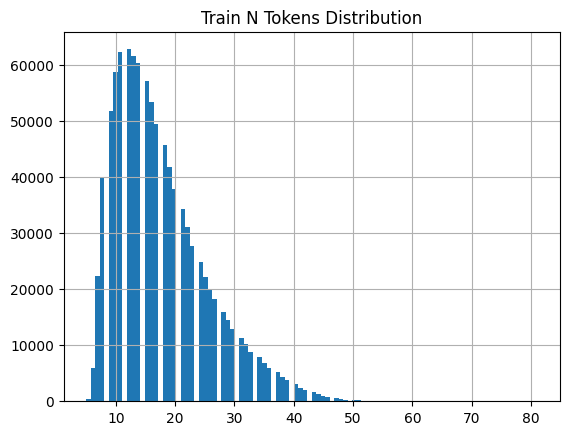

0.95 Quantile of N tokens: 33.0


In [78]:
# Here we want to figure out empirically max_length

train_n_tokens = geo_processed_df["tokens"].apply(len)

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [79]:
SEQ_LEN = 50

In [80]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df["tokens"].to_list(),
    targets=geo_processed_df["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
    # trim_policy="first"
)

In [81]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: ['Піар', 'був', 'відповідним', ',', 'не', 'гребували', 'нічим', ',', 'нові', '«', 'сенсаційні', '»', 'звинувачення', 'зливою', 'проливалися', 'на', 'обивателів', 'і', 'керівництво', '.']
Text Ids: tensor([143935,     78,   7737,      2,     12, 129365,   5837,      2,    384,
            16,  99576,     17,   2370,  74638, 477698,      5, 118153,      8,
          1378,      3,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])
Target: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
    

In [82]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[ 32390,   1621,      2,     25,  26837,   2850,      5,   3160,      9,
            979,      9,    137,      3,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     4,    114,     12,    821,    443,  12293,   2174,  35496,      3,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [    82,    101,  27317,  39469,     12, 230256, 146891, 343767, 211

In [83]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_text_ids = []
    all_losses = []
    all_targets = []
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            predicted_label = inp_model(text)
            loss = criterion(predicted_label, label)
            if mode == "train":
                loss.mean().backward()
                optimizer.step()
                
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_text_ids.append(text.detach().cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
            
    all_losses = np.concatenate(all_losses)
    all_text_ids = np.concatenate(all_text_ids)
    all_predicted_label = np.concatenate(all_predicted_label)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets, all_text_ids

In [84]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    rnn_channels=512,
    n_rnns=5,
    out_channels=1,
    average_type=None,
    bidirectional=True,
    dropout_rate=0.2
).to(global_device)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [85]:
train_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][0]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][0]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
)
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextTokenDataset(
    texts=geo_processed_df.iloc[folds_train_test_ids[0][1]]["tokens"].to_list(),
    targets=geo_processed_df.iloc[folds_train_test_ids[0][1]]["labels"].to_list(),
    dataset_vocab=vocab,
    max_length=SEQ_LEN,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [86]:
# Create by Chat GPT: https://chat.openai.com/share/1ebda1cb-c708-4e2b-ac63-b89e26ea4f1c

def extract_token_sequences(tensor, text_ids):
    extracted_texts = []

    # Add a False column at the beginning and end for detecting regions at boundaries
    tensor = np.column_stack((np.zeros(tensor.shape[0], dtype=bool), tensor, np.zeros(tensor.shape[0], dtype=bool)))

    for i, sequence in enumerate(tensor):
        # Find indices where values change
        diff = np.where(sequence[:-1] != sequence[1:])[0]
        
        sequence_texts = []
        for j in range(0, len(diff), 2):
            start, end = diff[j], diff[j+1]-1
            # Extract the token ids for the region and join them with "_"
            sequence_texts.append("_".join(map(str, text_ids[i, start:end+1])))
        
        extracted_texts.append(sequence_texts)

    return extracted_texts

def apply_connected_regions_and_compute_metric(
    y_true,
    y_pred,
    texts,
    tresh=0.5
):
    real_tokens = extract_token_sequences(
        y_true[:,:,0] > 0.5,
        texts
    )
    pred_tokens = extract_token_sequences(
        y_pred[:,:,0] > tresh,
        texts
    )

    return comp_metric(real_tokens, pred_tokens)

In [87]:
n_epochs = 3

train_all_epoch_losses = []
valid_all_epoch_losses = []
valid_metrics = []

best_metric = {
    "f1": - np.inf,
}
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    _, train_epoch_losses, _, _ = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="train"
    )
    # 1.2 Compute and print train metrics
    # Skip Train Metric in order to speed up training loop
    print("Train BCE loss:", train_epoch_losses.mean())
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets, valid_epoch_texts = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device=global_device,
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    valid_metric = apply_connected_regions_and_compute_metric(
        valid_epoch_targets, 
        valid_epoch_labels,
        valid_epoch_texts,
        tresh=0.5
    )
    print("Valid metric:", valid_metric)
    print("Valid BCE loss:", valid_epoch_losses.mean())
    # 3. Update learning rate (if needed)
    scheduler.step(valid_metric["f1"])
    # 4. Save best model
    if valid_metric["f1"] > best_metric["f1"]:
        best_metric = valid_metric
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate some stats  
    train_all_epoch_losses.append(train_epoch_losses)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_metrics.append(valid_metric)

Starting Epoch 1
Train phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [19:37<00:00, 21.45it/s]


Train BCE loss: 0.008344606
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:27<00:00, 114.10it/s]


Valid metric: {'precision': 0.8833882713683403, 'recall': 0.860331775491616, 'f1': 0.8717075901299566}
Valid BCE loss: 0.0058565596
Starting Epoch 2
Train phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [19:36<00:00, 21.45it/s]


Train BCE loss: 0.0048897383
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:27<00:00, 115.40it/s]


Valid metric: {'precision': 0.8825449110928112, 'recall': 0.8641094172278381, 'f1': 0.8732298731770617}
Valid BCE loss: 0.005590473
Starting Epoch 3
Train phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25250/25250 [19:41<00:00, 21.37it/s]


Train BCE loss: 0.0044785733
Valid phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [00:27<00:00, 114.02it/s]


Valid metric: {'precision': 0.8913670747874912, 'recall': 0.8533289534588565, 'f1': 0.8719333577444159}
Valid BCE loss: 0.0058920793
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.


> **TODO**: Here metric computation is not fully correct. Can you figure out what is a problem and how to fix it ?

Best Val Metrics: {'precision': 0.8825449110928112, 'recall': 0.8641094172278381, 'f1': 0.8732298731770617}


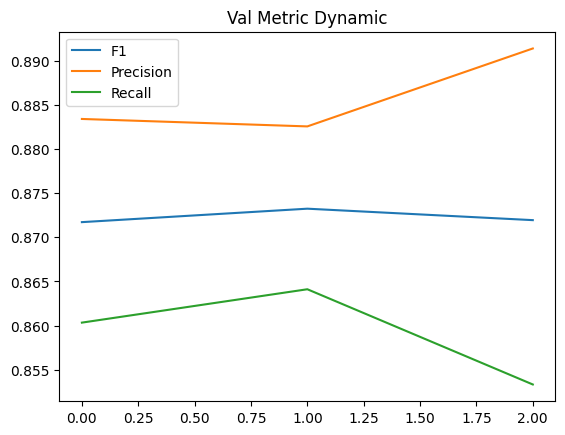

In [88]:
print("Best Val Metrics:", best_metric)
plt.title("Val Metric Dynamic")
plt.plot([el["f1"] for el in valid_metrics], label="F1")
plt.plot([el["precision"] for el in valid_metrics], label="Precision")
plt.plot([el["recall"] for el in valid_metrics], label="Recall")
plt.legend()
plt.show()

## Test on random Valid sample

In [89]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [90]:
valid_sample_index_with_locs = np.where(geo_dataset.iloc[folds_train_test_ids[0][1]].number_of_locations > 10)[0][0]

print("Sample text input:\n", geo_dataset.iloc[folds_train_test_ids[0][1]].iloc[valid_sample_index_with_locs].text)

text_idx, _ = valid_torch_dataset[valid_sample_index_with_locs]

with torch.inference_mode():
    test_sample_probs = torch.sigmoid(nn_model(text_idx[None,:].to(global_device))).detach().cpu().numpy()

predicted_ids = extract_token_sequences(
    test_sample_probs[:,:,0] > 0.5, 
    text_idx.numpy()[None,:]
)[0]

print("Our Prediction:")
pprint(set([" ".join(vocab.lookup_tokens([int(token) for token in el.split("_")])) for el in predicted_ids]))

Sample text input:
 Надзвичайний рівень переважатиме у Тернопільській, Хмельницькій, Вінницькій, Житомирській, Київській, Черкаській, Дніпропетрівській, Одеській, Миколаївській, Донецькій областях та в Криму.
Our Prediction:
{'Вінницькій',
 'Дніпропетрівській , Одеській , Миколаївській , Донецькій областях',
 'Житомирській',
 'Київській , Черкаській',
 'Криму',
 'Тернопільській',
 'Хмельницькій'}


> **TODO**: This case is very interesting. Maybe we need some post-processing

<a id='Homework'></a>
# Homework

Thoery (5 points):
- Complete theory questions in Google Form
- Take a look at all links 
- Read and analyze all theory `TODO`s. In this lecture they are highly important 

Practice (10-15 points):
- First Option (Easier) - Apply [Sentance Classification](#Sentance_Classification) approach to [CommonLit - Evaluate Student Summaries
](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries)
    - Max Base Points: 10
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyper-params
    - Try pre-trained word embeddings (do not use embeddings, trained with Transformer acrhitectures. We will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair and etc.
    - Implement Cross-Validation
    - Make a submit to Kaggle
- Second Option (Harder) - Apply [Token Classification](#Token_Classification) approach to Location Detection task
    - Max Base Points: 15
    - Introduce fixes, mentioned in `TODO`s
    - Your model also have to handle russian language. Make sure to add `../data/mantis_analytics_location_detection/ru_geo_dataset.csv` (from https://www.kaggle.com/datasets/vladimirsydor/mantis-analytics-location-detection/data). Think about
        - New Validation
        - New Word Embeddings
        - Maybe separate models
    - Coming back to Lecture 3. F1 is the final production metric but it hardly depends on threshold. Maybe you can use some "soft" metric for model comparison ? 
    - Is the ML model formalized correctly? In my approach there are only 2 types of labels (O and LOC) but if you check [huggingface example](https://huggingface.co/learn/nlp-course/chapter7/2), there will be 3 labels (O; B-LOC and I-LOC)
    - Do we need additional post-processing ?
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyper-params
    - Try pre-trained word embeddings (do not use embeddings, trained with Transformer acrhitectures. We will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair and etc.
    - Implement Cross-Validation
    - Upload best model + inference code on some cloud storage. So we can run it on our hidden test set. Make sure to open it ONLY for lectors
    - Additional points: first best test score - 25 points, second best test score - 15 points, third best test score - 10 points
- Third Option (Hardest). Do both first and second options
- Form will contain separate places for First and Second Options. Just put `-` for Option, which you have not choosen 